<a href="https://colab.research.google.com/github/SSM11011/WiDS-Molecular-Drug-Discovery-using-Graphical-Neutral-Networks/blob/main/GNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torch_geometric rdkit pubchempy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.3/33.3 MB 8.7 MB/s eta 0:00:00
  Created wheel for pubchempy: filename=PubChemPy-1.0.4-py3-none-any.whl size=13819 sha256=f0c85146b54c14e106adfaa618b804b08da863f2c91f091c40647850cdc70a20
  Stored in directory: /root/.cache/pip/wheels/90/7c/45/18a0671e3c3316966ef7ed9ad2b3f3300a7e41d3421a44e799
Successfully built pubchempy


In [ ]:
import warnings
warnings.filterwarnings('ignore')

Processing...
Done!


Epoch 10:
Train Loss: 4.2171
Test R²: 0.1282, RMSE: 2.0300, MAE: 1.6181
Epoch 20:
Train Loss: 3.7036
Test R²: 0.1780, RMSE: 1.9712, MAE: 1.5614
Epoch 30:
Train Loss: 3.6293
Test R²: 0.2269, RMSE: 1.9116, MAE: 1.5415
Epoch 40:
Train Loss: 2.8255
Test R²: 0.3203, RMSE: 1.7925, MAE: 1.4066
Epoch 50:
Train Loss: 2.5784
Test R²: 0.3708, RMSE: 1.7245, MAE: 1.3057
Epoch 60:
Train Loss: 2.4608
Test R²: 0.4702, RMSE: 1.5825, MAE: 1.2164
Epoch 70:
Train Loss: 2.2769
Test R²: 0.5422, RMSE: 1.4711, MAE: 1.1305
Epoch 80:
Train Loss: 1.9559
Test R²: 0.6089, RMSE: 1.3596, MAE: 1.0340
Epoch 90:
Train Loss: 1.7642
Test R²: 0.6343, RMSE: 1.3147, MAE: 1.0190
Epoch 100:
Train Loss: 2.2272
Test R²: 0.6014, RMSE: 1.3727, MAE: 1.0206


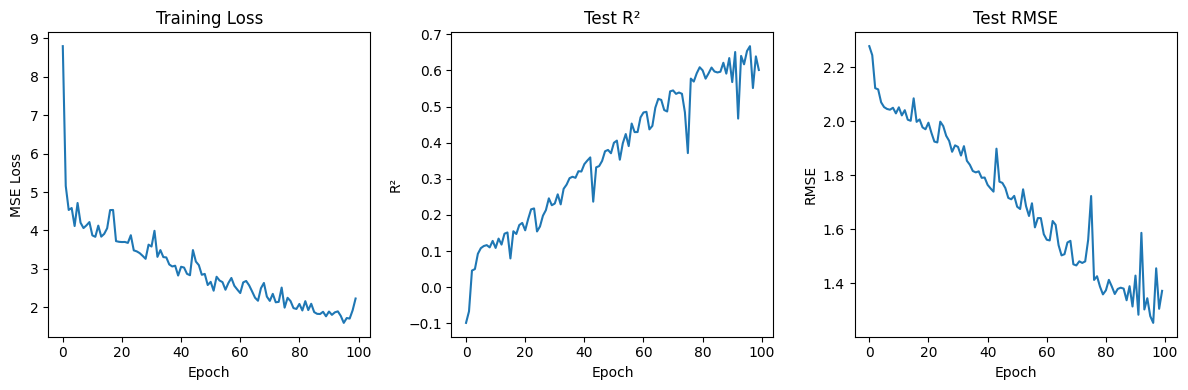

In [ ]:
# Import required libraries
import os
import math
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Dataset, DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool, GraphSAGE
from torch_geometric.datasets import MoleculeNet
from rdkit import Chem
from rdkit.Chem import Draw
import pubchempy as pcp
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Set random seed for reproducibility
torch.manual_seed(42)

# Load and preprocess MoleculeNet dataset
class LipophilicityDataset(Dataset):
    def __init__(self, root, transform=None, pre_transform=None):
        super().__init__(root, transform, pre_transform)
        self.data = MoleculeNet(root=root, name="ESOL")  # Using ESOL dataset which contains logP values

    def len(self):
        return len(self.data)

    def get(self, idx):
        return self.data[idx]

# Define the GNN model
class GNNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super(GNNModel, self).__init__()

        # GCN layers
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        # Skip connection layers
        self.skip1 = nn.Linear(input_dim, hidden_dim)
        self.skip2 = nn.Linear(hidden_dim, hidden_dim)

        # Output layers
        self.fc1 = nn.Linear(hidden_dim, hidden_dim//2)
        self.fc2 = nn.Linear(hidden_dim//2, output_dim)

        self.dropout = dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # First GCN layer with skip connection
        identity = self.skip1(x.float())
        x = self.conv1(x.float(), edge_index)
        x = F.relu(x + identity)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Second GCN layer with skip connection
        identity = self.skip2(x.float())
        x = self.conv2(x, edge_index)
        x = F.relu(x + identity)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # Third GCN layer
        x = self.conv3(x, edge_index)
        x = F.relu(x)

        # Global mean pooling
        x = global_mean_pool(x, batch)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.fc2(x)

        return x

# Training function
def train(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for data in loader:
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)

# Testing function
def test(model, loader):
    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for data in loader:
            out = model(data)
            predictions.extend(out.numpy())
            actuals.extend(data.y.numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    r2 = r2_score(actuals, predictions)
    rmse = np.sqrt(mean_squared_error(actuals, predictions))
    mae = mean_absolute_error(actuals, predictions)

    return r2, rmse, mae

# Main execution
def main():
    # Load dataset
    dataset = LipophilicityDataset(root='data/lipophilicity')

    # Split dataset
    train_idx, test_idx = train_test_split(
        range(len(dataset)), test_size=0.2, random_state=42)

    train_dataset = dataset[train_idx]
    test_dataset = dataset[test_idx]

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64)

    # Initialize model
    model = GNNModel(
        input_dim=dataset.num_features,
        hidden_dim=64,
        output_dim=1
    )

    # Setup training
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.MSELoss()

    # Training loop
    epochs = 100
    train_losses = []
    test_metrics = []

    for epoch in range(epochs):
        train_loss = train(model, train_loader, optimizer, criterion)
        r2, rmse, mae = test(model, test_loader)

        train_losses.append(train_loss)
        test_metrics.append((r2, rmse, mae))

        if (epoch + 1) % 10 == 0:
            print(f'Epoch {epoch+1}:')
            print(f'Train Loss: {train_loss:.4f}')
            print(f'Test R²: {r2:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}')

    # Plot metrics
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    plt.subplot(1, 3, 2)
    plt.plot([m[0] for m in test_metrics])
    plt.title('Test R²')
    plt.xlabel('Epoch')
    plt.ylabel('R²')

    plt.subplot(1, 3, 3)
    plt.plot([m[1] for m in test_metrics])
    plt.title('Test RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

Processing...
Done!


Dataset Attributes:
Lipophilicity(4200)
First Sample Attributes:
Data(x=[24, 9], edge_index=[2, 54], edge_attr=[54, 3], smiles='Cn1c(CN2CCN(CC2)c3ccc(Cl)cc3)nc4ccccc14', y=[1, 1])
Epoch: 1, Train Loss: 1.9273, Test MSE: 1.5144, Test MAE: 0.9965, Test R2: -0.0139
Epoch: 2, Train Loss: 1.4642, Test MSE: 1.5676, Test MAE: 1.0471, Test R2: -0.0496
Epoch: 3, Train Loss: 1.4532, Test MSE: 1.4924, Test MAE: 1.0106, Test R2: 0.0008
Epoch: 4, Train Loss: 1.4308, Test MSE: 1.4254, Test MAE: 0.9714, Test R2: 0.0457
Epoch: 5, Train Loss: 1.4356, Test MSE: 1.4057, Test MAE: 0.9578, Test R2: 0.0589
Epoch: 6, Train Loss: 1.4039, Test MSE: 1.3997, Test MAE: 0.9755, Test R2: 0.0628
Epoch: 7, Train Loss: 1.4219, Test MSE: 1.4002, Test MAE: 0.9445, Test R2: 0.0625
Epoch: 8, Train Loss: 1.4063, Test MSE: 1.3751, Test MAE: 0.9529, Test R2: 0.0793
Epoch: 9, Train Loss: 1.4186, Test MSE: 1.4052, Test MAE: 0.9807, Test R2: 0.0592
Epoch: 10, Train Loss: 1.3953, Test MSE: 1.3804, Test MAE: 0.9374, Test R2: 0.07

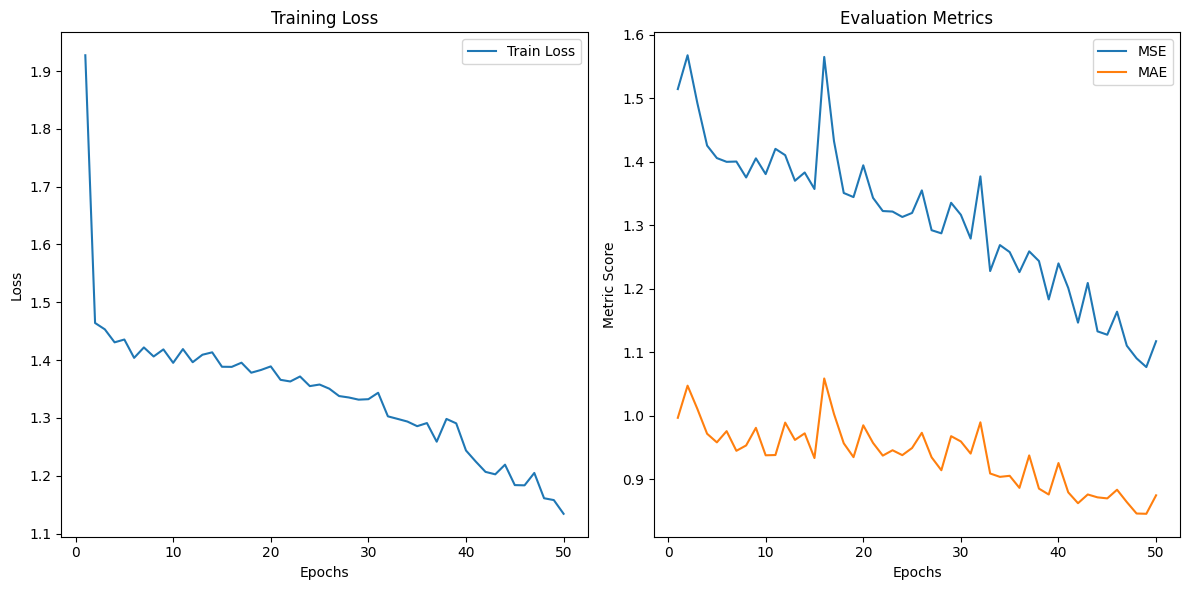

In [ ]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch_geometric.data import DataLoader
from torch_geometric.datasets import MoleculeNet
from torch_geometric.nn import GCNConv, global_mean_pool, global_add_pool
from torch.nn import Linear, Dropout
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Load and preprocess dataset
data_root = "./moleculenet"
dataset = MoleculeNet(root=data_root, name="lipo")

print("Dataset Attributes:")
print(dataset)
print("First Sample Attributes:")
print(dataset[0])

# Split dataset into train and test sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.fc1 = Linear(hidden_dim, hidden_dim // 2)
        self.fc2 = Linear(hidden_dim // 2, 1)
        self.dropout = Dropout(0.2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        # GCN layers with ReLU activation
        x = self.conv1(x.float(), edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv3(x, edge_index).relu()

        # Global pooling
        x = global_mean_pool(x, batch)  # Can experiment with global_add_pool

        # Fully connected layers
        x = self.dropout(x)
        x = self.fc1(x).relu()
        x = self.fc2(x)

        return x

# Initialize model, optimizer, and loss function
model = GNN(dataset.num_node_features, hidden_dim=128).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

def train(epoch):
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y.view(-1, 1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(train_dataset)

def test(loader):
    model.eval()
    preds, targets = [], []
    with torch.no_grad():
        for data in loader:
            data = data.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
            out = model(data).view(-1)
            preds.extend(out.cpu().numpy())
            targets.extend(data.y.cpu().numpy())
    mse = mean_squared_error(targets, preds)
    mae = mean_absolute_error(targets, preds)
    r2 = r2_score(targets, preds)
    return mse, mae, r2

# Training loop
train_losses = []
test_metrics = []
epochs = 50
for epoch in range(1, epochs + 1):
    train_loss = train(epoch)
    train_losses.append(train_loss)
    mse, mae, r2 = test(test_loader)
    test_metrics.append((mse, mae, r2))
    print(f"Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test MSE: {mse:.4f}, Test MAE: {mae:.4f}, Test R2: {r2:.4f}")

# Plot training and evaluation metrics
epochs_range = range(1, epochs + 1)
mse_values, mae_values, r2_values = zip(*test_metrics)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, mse_values, label='MSE')
plt.plot(epochs_range, mae_values, label='MAE')
plt.xlabel('Epochs')
plt.ylabel('Metric Score')
plt.title('Evaluation Metrics')
plt.legend()

plt.tight_layout()
plt.show()